# 5. Custom Neural Network for Tabular Data

### [2024.02.28] 이상혁

### 개요
- IDA 2016 Challenge에서 진행한 APS Failure and Operational Data for Scania Trucks 데이터를 이용하여, 결측치와 피쳐 수가 많은 데이터에 대한 이진 분류
- 한번 접해본 적이 있는 데이터지만, 시각화/결측치 보간/파생변수 생성 그리고 Neural Network를 활용한 모델링을 진행

### 1. Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import time
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchmetrics import Metric
from torchmetrics.classification import BinaryF1Score, BinaryAccuracy

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
# 시드 고정
def fixSEED(seed, deterministic=True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

fixSEED(seed=42)

### 2. EDA

In [4]:
# 데이터 불러오기
train = pd.read_csv('training_set.csv', encoding='utf-8-sig')
test = pd.read_csv('test_set.csv', encoding='utf-8-sig')

In [5]:
# 데이터 기본 정보 확인
print('--------Train data 기본 정보---------')
print('{}개의 행과 {}개의 열이 있습니다.'.format(train.shape[0], train.shape[1]))
print()
print('--------Train data 데이터 타입---------')
print(train.dtypes.unique())

--------Train data 기본 정보---------
55000개의 행과 172개의 열이 있습니다.

--------Train data 데이터 타입---------
[dtype('O') dtype('int64') dtype('float64')]


In [6]:
# ID_code 열 삭제
train.drop(['ID_code'], axis=1, inplace=True)
test.drop(['ID_code'], axis=1, inplace=True)

In [7]:
# 결측치 비율 확인
def missing_percentage(column, threshold):
    rows_missing = column.isna().sum()
    rows = len(column)
    percentage = rows_missing/rows * 100

    if percentage >= threshold:
        print('{}열의 결측치 개수는 {}개이고, 비율은 {:.4f}입니다.'.format(column.name, rows_missing, percentage))

    return percentage

In [8]:
# 결측치 70% 이상인 변수 확인
train.apply(lambda x: missing_percentage(x, threshold=70), axis=0)

X2열의 결측치 개수는 42415개이고, 비율은 77.1182입니다.
X39열의 결측치 개수는 40365개이고, 비율은 73.3909입니다.
X40열의 결측치 개수는 42482개이고, 비율은 77.2400입니다.
X41열의 결측치 개수는 43766개이고, 비율은 79.5745입니다.
X42열의 결측치 개수는 44660개이고, 비율은 81.2000입니다.
X43열의 결측치 개수는 45161개이고, 비율은 82.1109입니다.
X68열의 결측치 개수는 42415개이고, 비율은 77.1182입니다.


class     0.000000
X1        0.000000
X2       77.118182
X3        5.565455
X4       24.720000
           ...    
X105h     1.109091
X105i     1.109091
X105j     1.109091
X106      4.516364
X107      4.514545
Length: 171, dtype: float64

### 3. Pre-process

#### (1) 결측치 70% 이상인 열 제거

In [9]:
# 결측치 70% 이상인 열 제거
missing_drop_var = ['X2', 'X39', 'X40', 'X41', 'X42', 'X43', 'X68']

train.drop(columns=missing_drop_var, axis=1, inplace=True)
test.drop(columns=missing_drop_var, axis=1, inplace=True)

print(train.shape[1])

164


#### (2) 결측치 보간

- 결측치가 많이 발생하는 변수는 삭제해줬다.
- 따라서 KNN 등의 방법이 아닌 **중앙값**으로 결측치를 보간해준다.

In [10]:
# train data
for var in train.columns:
    if train[var].isna().sum() != 0:
        train[var][train[var].isna()] = train[var].median()

# test data
for var in test.columns:
    if test[var].isna().sum() != 0:
        test[var][test[var].isna()] = test[var].median()

In [11]:
# 결측치 확인
train.isna().sum()

class    0
X1       0
X3       0
X4       0
X5       0
        ..
X105h    0
X105i    0
X105j    0
X106     0
X107     0
Length: 164, dtype: int64

### 4. Dataset 및 Dataloader 정의

- 이제 학습 데이터는 모두 완료되었다.
- 학습용 데이터를 완성하고 이를 신경망에 입력하기 위한 데이터로더로 정의하자.

In [12]:
# target, label 분리
X = train.drop(columns='class', axis=1)
y = train['class']

In [13]:
# Train 데이터, Test 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # 클래스 불균형 데이터이기 때문에 stratify 적용

In [14]:
class CustomDataset(Dataset):
    def __init__(self, X_data: pd.DataFrame, y_data: pd.Series):

        # X_data와 y_data를 텐서로 변환
        self.X_data = torch.tensor(X_data.values, dtype=torch.float32)
        self.y_data = torch.tensor(y_data.values, dtype=torch.float32)
        
        # 크기 확인
        assert self.X_data.shape[0] == self.y_data.shape[0], "Feature와 Target의 길이가 일치하지 않습니다."

    def __len__(self):
        return len(self.y_data)

    def __getitem__(self, idx):
        x = self.X_data[idx]
        y = self.y_data[idx]

        return x, y

**참고**
- csv 형식의 데이터를 tensor로 만들어주기 위해서는 .values를 사용해야 한다.
- [Stackoverflow](https://stackoverflow.com/questions/51858067/parsing-csv-into-pytorch-tensors)를 참고함

In [15]:
# DataLoader 데이터 확인 및 Tensor 변환
print(X_train.shape, y_train.shape)  # X_train과 y_train shape 확인
assert X_train.shape[1] == 163, "Feature 개수 확인 필요"
assert len(y_train.shape) == 1, "Target shape이 (N,)인지 확인 필요"

(44000, 163) (44000,)


### 5. 모델 학습을 위한 함수 정의

In [16]:
# Trainer 함수에서 수정
def train_model(model, train_dataloader, criterion, optimizer, acc_metric, f1_metric, custom_metric, device):
    model.train()
    train_loss, train_acc, train_f1, train_cost = 0, 0, 0, 0

    for x, y in tqdm(train_dataloader, desc="Training"):
        x, y = x.to(device), y.to(device)

        outputs = model(x)
        loss = criterion(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = torch.sigmoid(outputs).round()  # Sigmoid 적용 후 0/1 변환
        train_loss += loss.item()
        train_acc += acc_metric(preds, y).item()
        train_f1 += f1_metric(preds, y).item()
        train_cost += custom_metric(preds, y).item()

    return (
        train_loss / len(train_dataloader),
        train_acc / len(train_dataloader),
        train_f1 / len(train_dataloader),
        train_cost / len(train_dataloader),
    )

def valid_model(model, valid_dataloader, criterion, acc_metric, f1_metric, custom_metric, device):
    model.eval()
    valid_loss, valid_acc, valid_f1, valid_cost = 0, 0, 0, 0

    with torch.no_grad():
        for x, y in tqdm(valid_dataloader, desc="Validation"):
            x, y = x.to(device), y.to(device)

            outputs = model(x)
            loss = criterion(outputs, y)

            preds = torch.sigmoid(outputs).round()  # Sigmoid 적용 후 0/1 변환
            valid_loss += loss.item()
            valid_acc += acc_metric(preds, y).item()
            valid_f1 += f1_metric(preds, y).item()
            valid_cost += custom_metric(preds, y).item()

    return (
        valid_loss / len(valid_dataloader),
        valid_acc / len(valid_dataloader),
        valid_f1 / len(valid_dataloader),
        valid_cost / len(valid_dataloader),
    )

def trainer(model, train_dataloader, valid_dataloader, criterion, optimizer, scheduler, acc_metric, f1_metric, custom_metric, device, num_epochs, wait_for_es, save=False):
    train_loss_history, train_acc_history, train_f1_history, train_cost_history = [], [], [], []  # 훈련 기록
    valid_loss_history, valid_acc_history, valid_f1_history, valid_cost_history = [], [], [], []  # 평가 기록

    best_loss = float('inf')
    best_acc = 0
    count = 0

    start_time = time.time()

    for epoch in range(num_epochs):
        print('-' * 80)
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 80)

        train_loss, train_acc, train_f1, train_cost = train_model(
            model, train_dataloader, criterion, optimizer, acc_metric, f1_metric, custom_metric, device
        )
        valid_loss, valid_acc, valid_f1, valid_cost = valid_model(
            model, valid_dataloader, criterion, acc_metric, f1_metric, custom_metric, device
        )

        scheduler.step()  # 학습률 감소 스케줄 적용

        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        train_f1_history.append(train_f1)
        train_cost_history.append(train_cost)

        valid_loss_history.append(valid_loss)
        valid_acc_history.append(valid_acc)
        valid_f1_history.append(valid_f1)
        valid_cost_history.append(valid_cost)

        elapsed_time = time.time() - start_time

        print(f'[Train] Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, Cost: {train_cost:.4f}')
        print(f'[Valid] Loss: {valid_loss:.4f}, Acc: {valid_acc:.4f}, F1: {valid_f1:.4f}, Cost: {valid_cost:.4f}')
        print(f'(Epoch {epoch + 1} complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s)')

        if save and valid_acc > best_acc:
            best_acc = valid_acc
            torch.save(model.state_dict(), f'./model/CustomDNN_epoch{epoch + 1}.pth')

        if valid_loss < best_loss:
            best_loss = valid_loss
            count = 0  # Early stopping 조건 초기화
        else:
            count += 1
            if count >= wait_for_es:
                print(f'-----<Early Stopping at Epoch {epoch + 1}>-----')
                break

    return train_loss_history, train_acc_history, train_f1_history, train_cost_history, valid_loss_history, valid_acc_history, valid_f1_history, valid_cost_history

In [17]:
class CustomMetric(Metric):
    def __init__(self):
        super().__init__()
        # 상태 변수 정의
        self.add_state("false_negatives", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("false_positives", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        """
        Metric 업데이트: preds와 target을 비교하여 false negatives와 false positives를 계산.
        """
        # 0 또는 1로 이진화
        preds = torch.round(torch.sigmoid(preds))  # Sigmoid 적용 후 이진화
        target = target.int()  # target도 정수로 변환

        # False negatives: 실제 1인데 예측이 0인 경우
        self.false_negatives += ((preds == 0) & (target == 1)).sum().item()
        # False positives: 실제 0인데 예측이 1인 경우
        self.false_positives += ((preds == 1) & (target == 0)).sum().item()

    def compute(self):
        """
        최종 Metric 계산: false negatives와 false positives를 기반으로 cost 계산.
        """
        return 250 * self.false_negatives + 5 * self.false_positives


이제 학습을 평가하기 위한 Metric을 작성한다. 정확도와 F1 점수는 PyTorch Metrics이 존재하지만, Cost 함수는 존재하기 없기 때문에 Custom Metrics을 작성해야 한다.
- 다음의 [링크](https://lightning.ai/docs/torchmetrics/stable/pages/implement.html)를 참고해서 작성했다.

### 6. 모델 정의

모델 학습과 평가를 위한 함수를 모두 작성했다. 이제 모델을 정의하고 학습시켜보자.

In [18]:
class CustomDNN(nn.Module):
    def __init__(self):
        super(CustomDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=163, out_features=80)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(in_features=80, out_features=40)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(in_features=40, out_features=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.drop1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.drop2(out)
        out = self.fc3(out)  # Sigmoid 제거 (BCEWithLogitsLoss 사용)
        return out.squeeze()  # [batch_size] 형태로 조정

In [19]:
# 모델 정의
model = CustomDNN()
model.to(device)

CustomDNN(
  (fc1): Linear(in_features=163, out_features=80, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=80, out_features=40, bias=True)
  (relu2): ReLU()
  (drop2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=40, out_features=1, bias=True)
)

In [20]:
# 모델 파라미터 개수 확인
summary(model, input_size=(163, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 80]          13,120
              ReLU-2                   [-1, 80]               0
           Dropout-3                   [-1, 80]               0
            Linear-4                   [-1, 40]           3,240
              ReLU-5                   [-1, 40]               0
           Dropout-6                   [-1, 40]               0
            Linear-7                    [-1, 1]              41
Total params: 16,401
Trainable params: 16,401
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.06
Estimated Total Size (MB): 0.07
----------------------------------------------------------------


In [21]:
# trainable parameter 확인 방법
def count_parameter(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameter(model):,} trainable parameters')

The model has 16,401 trainable parameters


### 7. Config와 파라미터 정의

In [22]:
pos_weight = torch.tensor(
    [y_train.value_counts()[0] / y_train.value_counts()[1]], dtype=torch.float32
).to(device)

In [23]:
# 옵티마이저, 손실 함수, Metric 정의
model = CustomDNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 초기 학습률 설정
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)  # 데이터 불균형 보정
acc_metric = BinaryAccuracy(threshold=0.5).to(device)  # 0.5 기준 정확도 계산
f1_metric = BinaryF1Score(threshold=0.5).to(device)
custom_metric = CustomMetric().to(device)

# 학습률 스케줄러 추가
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [24]:
# 파라미터 정의
num_epochs = 200
wait_for_es = 30
batch_size = 256

In [25]:
# 데이터셋 정의
train_dataset = CustomDataset(X_train, y_train)
valid_dataset = CustomDataset(X_val, y_val)

In [26]:
# 데이터로더 정의
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

next(iter(train_dataloader))

[tensor([[7.2200e+03, 4.7200e+02, 4.4400e+02,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [4.0682e+04, 4.8200e+02, 4.6600e+02,  ..., 3.0680e+03, 0.0000e+00,
          0.0000e+00],
         [1.0494e+04, 6.2000e+01, 4.8000e+01,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         ...,
         [1.6000e+01, 1.6000e+01, 1.4000e+01,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [6.4140e+04, 2.1307e+09, 1.2860e+03,  ..., 3.5760e+03, 0.0000e+00,
          0.0000e+00]]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

### 8. 학습 진행

In [27]:
# 학습 실행
train_loss_history, train_acc_history, train_f1_history, train_cost_history, valid_loss_history, valid_acc_history, valid_f1_history, valid_cost_history = trainer(
    model,
    train_dataloader,
    val_dataloader,
    criterion,
    optimizer,
    scheduler,
    acc_metric,
    f1_metric,
    custom_metric,
    device,
    num_epochs=num_epochs,
    wait_for_es=wait_for_es,
)

--------------------------------------------------------------------------------
Epoch 1/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 854.33it/s]


[Train] Loss: 453745.3114, Acc: 0.6304, F1: 0.0775, Cost: 603.8372
[Valid] Loss: 50056.3215, Acc: 0.8641, F1: 0.1906, Cost: 213.7209
(Epoch 1 complete in 0m 0s)
--------------------------------------------------------------------------------
Epoch 2/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 872.65it/s]


[Train] Loss: 102159.7216, Acc: 0.6577, F1: 0.0785, Cost: 584.7093
[Valid] Loss: 12664.5519, Acc: 0.9155, F1: 0.2041, Cost: 466.9767
(Epoch 2 complete in 0m 1s)
--------------------------------------------------------------------------------
Epoch 3/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 865.81it/s]


[Train] Loss: 29265.4253, Acc: 0.7474, F1: 0.0845, Cost: 699.1279
[Valid] Loss: 1474.7446, Acc: 0.6047, F1: 0.0239, Cost: 1246.3953
(Epoch 3 complete in 0m 1s)
--------------------------------------------------------------------------------
Epoch 4/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 882.32it/s]


[Train] Loss: 11988.0764, Acc: 0.8316, F1: 0.0957, Cost: 796.5698
[Valid] Loss: 372.8645, Acc: 0.9827, F1: 0.0287, Cost: 1053.3721
(Epoch 4 complete in 0m 2s)
--------------------------------------------------------------------------------
Epoch 5/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 681.90it/s]


[Train] Loss: 6460.9142, Acc: 0.8922, F1: 0.1029, Cost: 831.5698
[Valid] Loss: 187.7786, Acc: 0.8222, F1: 0.0058, Cost: 1247.3256
(Epoch 5 complete in 0m 2s)
--------------------------------------------------------------------------------
Epoch 6/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 753.42it/s]


[Train] Loss: 1845.4064, Acc: 0.8967, F1: 0.0941, Cost: 919.7384
[Valid] Loss: 219.9700, Acc: 0.8202, F1: 0.0059, Cost: 1249.8837
(Epoch 6 complete in 0m 2s)
--------------------------------------------------------------------------------
Epoch 7/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 524.95it/s]


[Train] Loss: 1130.8127, Acc: 0.9257, F1: 0.1023, Cost: 878.0523
[Valid] Loss: 15.3075, Acc: 0.2941, F1: 0.0451, Cost: 908.6047
(Epoch 7 complete in 0m 3s)
--------------------------------------------------------------------------------
Epoch 8/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 849.21it/s]


[Train] Loss: 1119.1742, Acc: 0.4415, F1: 0.0534, Cost: 772.8198
[Valid] Loss: 24.4401, Acc: 0.3376, F1: 0.0479, Cost: 853.0233
(Epoch 8 complete in 0m 3s)
--------------------------------------------------------------------------------
Epoch 9/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 833.98it/s]


[Train] Loss: 734.8947, Acc: 0.3898, F1: 0.0497, Cost: 830.2907
[Valid] Loss: 13.3029, Acc: 0.3272, F1: 0.0472, Cost: 866.2791
(Epoch 9 complete in 0m 4s)
--------------------------------------------------------------------------------
Epoch 10/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 832.25it/s]


[Train] Loss: 599.5480, Acc: 0.3448, F1: 0.0466, Cost: 885.0291
[Valid] Loss: 15.1616, Acc: 0.3253, F1: 0.0470, Cost: 868.7209
(Epoch 10 complete in 0m 4s)
--------------------------------------------------------------------------------
Epoch 11/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 839.37it/s]


[Train] Loss: 573.8720, Acc: 0.3160, F1: 0.0455, Cost: 899.1279
[Valid] Loss: 14.9447, Acc: 0.3249, F1: 0.0470, Cost: 869.1860
(Epoch 11 complete in 0m 4s)
--------------------------------------------------------------------------------
Epoch 12/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 819.46it/s]


[Train] Loss: 414.0298, Acc: 0.2941, F1: 0.0442, Cost: 931.4244
[Valid] Loss: 15.4464, Acc: 0.3241, F1: 0.0469, Cost: 870.2326
(Epoch 12 complete in 0m 5s)
--------------------------------------------------------------------------------
Epoch 13/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 837.31it/s]


[Train] Loss: 295.3841, Acc: 0.3209, F1: 0.0457, Cost: 898.5465
[Valid] Loss: 16.2045, Acc: 0.3216, F1: 0.0468, Cost: 873.3721
(Epoch 13 complete in 0m 5s)
--------------------------------------------------------------------------------
Epoch 14/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 848.78it/s]


[Train] Loss: 248.6017, Acc: 0.2897, F1: 0.0444, Cost: 924.1860
[Valid] Loss: 16.6130, Acc: 0.3231, F1: 0.0469, Cost: 871.5116
(Epoch 14 complete in 0m 6s)
--------------------------------------------------------------------------------
Epoch 15/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 862.48it/s]


[Train] Loss: 223.2320, Acc: 0.3087, F1: 0.0456, Cost: 899.7965
[Valid] Loss: 16.6048, Acc: 0.2481, F1: 0.0425, Cost: 967.4419
(Epoch 15 complete in 0m 6s)
--------------------------------------------------------------------------------
Epoch 16/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 853.58it/s]


[Train] Loss: 492.3048, Acc: 0.3112, F1: 0.0449, Cost: 922.3837
[Valid] Loss: 16.8835, Acc: 0.3245, F1: 0.0470, Cost: 869.7674
(Epoch 16 complete in 0m 6s)
--------------------------------------------------------------------------------
Epoch 17/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 861.78it/s]


[Train] Loss: 249.1754, Acc: 0.3350, F1: 0.0463, Cost: 887.6744
[Valid] Loss: 16.8944, Acc: 0.3235, F1: 0.0469, Cost: 871.0465
(Epoch 17 complete in 0m 7s)
--------------------------------------------------------------------------------
Epoch 18/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 851.00it/s]


[Train] Loss: 575.4218, Acc: 0.3371, F1: 0.0470, Cost: 870.7267
[Valid] Loss: 12.6366, Acc: 0.3214, F1: 0.0468, Cost: 873.7209
(Epoch 18 complete in 0m 7s)
--------------------------------------------------------------------------------
Epoch 19/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 841.98it/s]


[Train] Loss: 268.4250, Acc: 0.3297, F1: 0.0462, Cost: 891.5698
[Valid] Loss: 12.4292, Acc: 0.3215, F1: 0.0468, Cost: 873.6047
(Epoch 19 complete in 0m 8s)
--------------------------------------------------------------------------------
Epoch 20/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 832.04it/s]


[Train] Loss: 204.0685, Acc: 0.3390, F1: 0.0470, Cost: 868.2849
[Valid] Loss: 11.6789, Acc: 0.3220, F1: 0.0468, Cost: 872.9070
(Epoch 20 complete in 0m 8s)
--------------------------------------------------------------------------------
Epoch 21/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 833.83it/s]


[Train] Loss: 791.2026, Acc: 0.3543, F1: 0.0478, Cost: 855.8430
[Valid] Loss: 11.5606, Acc: 0.3216, F1: 0.0468, Cost: 873.3721
(Epoch 21 complete in 0m 8s)
--------------------------------------------------------------------------------
Epoch 22/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 870.50it/s]


[Train] Loss: 208.8942, Acc: 0.3439, F1: 0.0478, Cost: 852.0349
[Valid] Loss: 11.5064, Acc: 0.3216, F1: 0.0468, Cost: 873.4884
(Epoch 22 complete in 0m 9s)
--------------------------------------------------------------------------------
Epoch 23/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 849.60it/s]


[Train] Loss: 136.4055, Acc: 0.2970, F1: 0.0440, Cost: 932.0058
[Valid] Loss: 11.4598, Acc: 0.3027, F1: 0.0456, Cost: 897.6744
(Epoch 23 complete in 0m 9s)
--------------------------------------------------------------------------------
Epoch 24/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 365.48it/s]


[Train] Loss: 102.6238, Acc: 0.3403, F1: 0.0462, Cost: 887.8779
[Valid] Loss: 11.4523, Acc: 0.2409, F1: 0.0421, Cost: 976.6279
(Epoch 24 complete in 0m 10s)
--------------------------------------------------------------------------------
Epoch 25/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 826.88it/s]


[Train] Loss: 485.6256, Acc: 0.3111, F1: 0.0448, Cost: 919.5640
[Valid] Loss: 11.3385, Acc: 0.2941, F1: 0.0451, Cost: 908.6047
(Epoch 25 complete in 0m 10s)
--------------------------------------------------------------------------------
Epoch 26/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 846.44it/s]


[Train] Loss: 677.4512, Acc: 0.3321, F1: 0.0465, Cost: 884.2442
[Valid] Loss: 11.4494, Acc: 0.2387, F1: 0.0420, Cost: 979.5349
(Epoch 26 complete in 0m 10s)
--------------------------------------------------------------------------------
Epoch 27/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 785.00it/s]


[Train] Loss: 113.1445, Acc: 0.3029, F1: 0.0447, Cost: 921.5116
[Valid] Loss: 11.4449, Acc: 0.2339, F1: 0.0417, Cost: 985.5814
(Epoch 27 complete in 0m 11s)
--------------------------------------------------------------------------------
Epoch 28/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 798.34it/s]


[Train] Loss: 1136.0575, Acc: 0.3400, F1: 0.0464, Cost: 887.0058
[Valid] Loss: 11.1462, Acc: 0.3115, F1: 0.0462, Cost: 886.3953
(Epoch 28 complete in 0m 11s)
--------------------------------------------------------------------------------
Epoch 29/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 853.29it/s]


[Train] Loss: 290.3226, Acc: 0.3411, F1: 0.0474, Cost: 866.9477
[Valid] Loss: 11.0146, Acc: 0.3165, F1: 0.0465, Cost: 880.0000
(Epoch 29 complete in 0m 11s)
--------------------------------------------------------------------------------
Epoch 30/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 831.08it/s]


[Train] Loss: 133.7370, Acc: 0.3174, F1: 0.0451, Cost: 910.0581
[Valid] Loss: 10.8584, Acc: 0.2461, F1: 0.0424, Cost: 970.0000
(Epoch 30 complete in 0m 12s)
--------------------------------------------------------------------------------
Epoch 31/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 536.12it/s]


[Train] Loss: 983.9547, Acc: 0.2766, F1: 0.0429, Cost: 956.6860
[Valid] Loss: 10.8557, Acc: 0.2388, F1: 0.0420, Cost: 979.3023
(Epoch 31 complete in 0m 12s)
--------------------------------------------------------------------------------
Epoch 32/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 721.90it/s]


[Train] Loss: 73.9076, Acc: 0.3033, F1: 0.0449, Cost: 916.8314
[Valid] Loss: 10.8222, Acc: 0.2340, F1: 0.0417, Cost: 985.4651
(Epoch 32 complete in 0m 13s)
--------------------------------------------------------------------------------
Epoch 33/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 842.20it/s]


[Train] Loss: 21.9852, Acc: 0.3051, F1: 0.0447, Cost: 915.8140
[Valid] Loss: 10.8199, Acc: 0.2606, F1: 0.0432, Cost: 951.3953
(Epoch 33 complete in 0m 13s)
--------------------------------------------------------------------------------
Epoch 34/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 845.32it/s]


[Train] Loss: 926.9707, Acc: 0.2882, F1: 0.0439, Cost: 938.8953
[Valid] Loss: 10.8172, Acc: 0.2356, F1: 0.0418, Cost: 983.4884
(Epoch 34 complete in 0m 13s)
--------------------------------------------------------------------------------
Epoch 35/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 847.86it/s]


[Train] Loss: 2128.6116, Acc: 0.2839, F1: 0.0433, Cost: 945.8721
[Valid] Loss: 10.8004, Acc: 0.2346, F1: 0.0418, Cost: 984.7674
(Epoch 35 complete in 0m 14s)
--------------------------------------------------------------------------------
Epoch 36/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 819.83it/s]


[Train] Loss: 217.0831, Acc: 0.2992, F1: 0.0449, Cost: 913.4012
[Valid] Loss: 10.7921, Acc: 0.3005, F1: 0.0455, Cost: 900.4651
(Epoch 36 complete in 0m 14s)
--------------------------------------------------------------------------------
Epoch 37/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 841.75it/s]


[Train] Loss: 637.6161, Acc: 0.3245, F1: 0.0460, Cost: 893.8953
[Valid] Loss: 10.8028, Acc: 0.3026, F1: 0.0456, Cost: 897.7907
(Epoch 37 complete in 0m 15s)
--------------------------------------------------------------------------------
Epoch 38/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 838.19it/s]


[Train] Loss: 168.1805, Acc: 0.2970, F1: 0.0441, Cost: 927.7035
[Valid] Loss: 10.8087, Acc: 0.2353, F1: 0.0418, Cost: 983.8372
(Epoch 38 complete in 0m 15s)
--------------------------------------------------------------------------------
Epoch 39/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 830.79it/s]


[Train] Loss: 215.9150, Acc: 0.2908, F1: 0.0438, Cost: 938.4593
[Valid] Loss: 10.7749, Acc: 0.2855, F1: 0.0446, Cost: 919.6512
(Epoch 39 complete in 0m 15s)
--------------------------------------------------------------------------------
Epoch 40/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 847.49it/s]


[Train] Loss: 437.7777, Acc: 0.2902, F1: 0.0437, Cost: 940.6686
[Valid] Loss: 10.7507, Acc: 0.2372, F1: 0.0419, Cost: 981.3953
(Epoch 40 complete in 0m 16s)
--------------------------------------------------------------------------------
Epoch 41/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 836.22it/s]


[Train] Loss: 845.5105, Acc: 0.2952, F1: 0.0440, Cost: 932.7326
[Valid] Loss: 10.7428, Acc: 0.2364, F1: 0.0419, Cost: 982.4419
(Epoch 41 complete in 0m 16s)
--------------------------------------------------------------------------------
Epoch 42/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 522.75it/s]


[Train] Loss: 106.2071, Acc: 0.2690, F1: 0.0431, Cost: 950.6686
[Valid] Loss: 10.7435, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 42 complete in 0m 16s)
--------------------------------------------------------------------------------
Epoch 43/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 818.92it/s]


[Train] Loss: 1791.8727, Acc: 0.2530, F1: 0.0420, Cost: 978.2558
[Valid] Loss: 10.7435, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 43 complete in 0m 17s)
--------------------------------------------------------------------------------
Epoch 44/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 833.93it/s]


[Train] Loss: 225.8730, Acc: 0.2620, F1: 0.0425, Cost: 965.3488
[Valid] Loss: 10.7426, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 44 complete in 0m 17s)
--------------------------------------------------------------------------------
Epoch 45/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 366.70it/s]


[Train] Loss: 98.1517, Acc: 0.2640, F1: 0.0424, Cost: 965.5523
[Valid] Loss: 10.7426, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 45 complete in 0m 18s)
--------------------------------------------------------------------------------
Epoch 46/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 850.09it/s]


[Train] Loss: 115.4156, Acc: 0.2507, F1: 0.0420, Cost: 975.5233
[Valid] Loss: 10.7427, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 46 complete in 0m 18s)
--------------------------------------------------------------------------------
Epoch 47/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 832.16it/s]


[Train] Loss: 48.2749, Acc: 0.2587, F1: 0.0424, Cost: 966.7151
[Valid] Loss: 10.7419, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 47 complete in 0m 18s)
--------------------------------------------------------------------------------
Epoch 48/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 847.51it/s]


[Train] Loss: 224.1732, Acc: 0.2541, F1: 0.0417, Cost: 979.6802
[Valid] Loss: 10.7422, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 48 complete in 0m 19s)
--------------------------------------------------------------------------------
Epoch 49/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 849.22it/s]


[Train] Loss: 94.3946, Acc: 0.2452, F1: 0.0415, Cost: 988.1977
[Valid] Loss: 10.7405, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 49 complete in 0m 19s)
--------------------------------------------------------------------------------
Epoch 50/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 834.04it/s]


[Train] Loss: 65.0346, Acc: 0.2443, F1: 0.0415, Cost: 989.3895
[Valid] Loss: 10.7391, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 50 complete in 0m 20s)
--------------------------------------------------------------------------------
Epoch 51/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 795.12it/s]


[Train] Loss: 113.1112, Acc: 0.2440, F1: 0.0417, Cost: 982.6744
[Valid] Loss: 10.7392, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 51 complete in 0m 20s)
--------------------------------------------------------------------------------
Epoch 52/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 845.64it/s]


[Train] Loss: 157.5336, Acc: 0.2473, F1: 0.0418, Cost: 982.6744
[Valid] Loss: 10.7390, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 52 complete in 0m 20s)
--------------------------------------------------------------------------------
Epoch 53/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 514.62it/s]


[Train] Loss: 125.8948, Acc: 0.2484, F1: 0.0420, Cost: 975.5814
[Valid] Loss: 10.7384, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 53 complete in 0m 21s)
--------------------------------------------------------------------------------
Epoch 54/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 842.39it/s]


[Train] Loss: 182.0836, Acc: 0.2456, F1: 0.0415, Cost: 987.6744
[Valid] Loss: 10.7388, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 54 complete in 0m 21s)
--------------------------------------------------------------------------------
Epoch 55/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 840.70it/s]


[Train] Loss: 211.1479, Acc: 0.2421, F1: 0.0416, Cost: 987.9070
[Valid] Loss: 10.7379, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 55 complete in 0m 21s)
--------------------------------------------------------------------------------
Epoch 56/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 844.78it/s]


[Train] Loss: 148.2117, Acc: 0.2406, F1: 0.0416, Cost: 987.0058
[Valid] Loss: 10.7379, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 56 complete in 0m 22s)
--------------------------------------------------------------------------------
Epoch 57/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 816.42it/s]


[Train] Loss: 214.1532, Acc: 0.2448, F1: 0.0418, Cost: 981.7151
[Valid] Loss: 10.7371, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 57 complete in 0m 22s)
--------------------------------------------------------------------------------
Epoch 58/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 857.43it/s]


[Train] Loss: 130.1371, Acc: 0.2403, F1: 0.0411, Cost: 998.7209
[Valid] Loss: 10.7368, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 58 complete in 0m 23s)
--------------------------------------------------------------------------------
Epoch 59/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 847.84it/s]


[Train] Loss: 1439.7654, Acc: 0.2381, F1: 0.0418, Cost: 981.6860
[Valid] Loss: 10.7366, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 59 complete in 0m 23s)
--------------------------------------------------------------------------------
Epoch 60/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 840.44it/s]


[Train] Loss: 208.8235, Acc: 0.2404, F1: 0.0417, Cost: 985.8140
[Valid] Loss: 10.7366, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 60 complete in 0m 23s)
--------------------------------------------------------------------------------
Epoch 61/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 827.98it/s]


[Train] Loss: 202.7617, Acc: 0.2410, F1: 0.0415, Cost: 987.9651
[Valid] Loss: 10.7366, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 61 complete in 0m 24s)
--------------------------------------------------------------------------------
Epoch 62/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 820.63it/s]


[Train] Loss: 113.7610, Acc: 0.2439, F1: 0.0417, Cost: 982.7616
[Valid] Loss: 10.7366, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 62 complete in 0m 24s)
--------------------------------------------------------------------------------
Epoch 63/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 845.29it/s]


[Train] Loss: 577.5070, Acc: 0.2402, F1: 0.0412, Cost: 997.4128
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 63 complete in 0m 25s)
--------------------------------------------------------------------------------
Epoch 64/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 836.74it/s]


[Train] Loss: 192.6776, Acc: 0.2437, F1: 0.0420, Cost: 975.9593
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 64 complete in 0m 25s)
--------------------------------------------------------------------------------
Epoch 65/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 789.57it/s]


[Train] Loss: 92.6040, Acc: 0.2445, F1: 0.0419, Cost: 979.1860
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 65 complete in 0m 25s)
--------------------------------------------------------------------------------
Epoch 66/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 827.13it/s]


[Train] Loss: 102.3945, Acc: 0.2427, F1: 0.0419, Cost: 978.5756
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 66 complete in 0m 26s)
--------------------------------------------------------------------------------
Epoch 67/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 836.27it/s]


[Train] Loss: 1217.9961, Acc: 0.2409, F1: 0.0413, Cost: 993.7209
[Valid] Loss: 10.7366, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 67 complete in 0m 26s)
--------------------------------------------------------------------------------
Epoch 68/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 814.95it/s]


[Train] Loss: 272.3605, Acc: 0.2431, F1: 0.0416, Cost: 985.2035
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 68 complete in 0m 27s)
--------------------------------------------------------------------------------
Epoch 69/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 492.42it/s]


[Train] Loss: 186.8757, Acc: 0.2426, F1: 0.0417, Cost: 981.5698
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 69 complete in 0m 27s)
--------------------------------------------------------------------------------
Epoch 70/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 824.96it/s]


[Train] Loss: 52.4360, Acc: 0.2415, F1: 0.0415, Cost: 990.0872
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 70 complete in 0m 27s)
--------------------------------------------------------------------------------
Epoch 71/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 349.68it/s]


[Train] Loss: 616.4943, Acc: 0.2417, F1: 0.0418, Cost: 978.4884
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 71 complete in 0m 28s)
--------------------------------------------------------------------------------
Epoch 72/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 813.64it/s]


[Train] Loss: 157.1492, Acc: 0.2414, F1: 0.0417, Cost: 981.7151
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 72 complete in 0m 28s)
--------------------------------------------------------------------------------
Epoch 73/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 851.21it/s]


[Train] Loss: 732.9598, Acc: 0.2444, F1: 0.0420, Cost: 977.8198
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 73 complete in 0m 29s)
--------------------------------------------------------------------------------
Epoch 74/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 811.21it/s]


[Train] Loss: 1555.8872, Acc: 0.2429, F1: 0.0415, Cost: 985.4651
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 74 complete in 0m 29s)
--------------------------------------------------------------------------------
Epoch 75/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 735.30it/s]


[Train] Loss: 92.1886, Acc: 0.2407, F1: 0.0415, Cost: 988.3430
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 75 complete in 0m 29s)
--------------------------------------------------------------------------------
Epoch 76/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 817.74it/s]


[Train] Loss: 138.9546, Acc: 0.2426, F1: 0.0417, Cost: 981.5407
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 76 complete in 0m 30s)
--------------------------------------------------------------------------------
Epoch 77/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 817.50it/s]


[Train] Loss: 104.1531, Acc: 0.2401, F1: 0.0414, Cost: 993.3721
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 77 complete in 0m 30s)
--------------------------------------------------------------------------------
Epoch 78/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 841.82it/s]


[Train] Loss: 367.8898, Acc: 0.2414, F1: 0.0415, Cost: 988.7500
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 78 complete in 0m 30s)
--------------------------------------------------------------------------------
Epoch 79/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 823.03it/s]


[Train] Loss: 181.0941, Acc: 0.2403, F1: 0.0415, Cost: 988.8663
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 79 complete in 0m 31s)
--------------------------------------------------------------------------------
Epoch 80/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 504.48it/s]


[Train] Loss: 657.6919, Acc: 0.2399, F1: 0.0414, Cost: 992.1221
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 80 complete in 0m 31s)
--------------------------------------------------------------------------------
Epoch 81/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 824.48it/s]


[Train] Loss: 2789.5044, Acc: 0.2408, F1: 0.0415, Cost: 989.5640
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 81 complete in 0m 32s)
--------------------------------------------------------------------------------
Epoch 82/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 835.08it/s]


[Train] Loss: 120.2847, Acc: 0.2418, F1: 0.0417, Cost: 984.0407
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 82 complete in 0m 32s)
--------------------------------------------------------------------------------
Epoch 83/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 832.72it/s]


[Train] Loss: 331.6200, Acc: 0.2424, F1: 0.0412, Cost: 993.2267
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 83 complete in 0m 32s)
--------------------------------------------------------------------------------
Epoch 84/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 837.42it/s]


[Train] Loss: 2277.6872, Acc: 0.2423, F1: 0.0416, Cost: 986.3081
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 84 complete in 0m 33s)
--------------------------------------------------------------------------------
Epoch 85/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 799.97it/s]


[Train] Loss: 2787.8699, Acc: 0.2421, F1: 0.0414, Cost: 990.7267
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 85 complete in 0m 33s)
--------------------------------------------------------------------------------
Epoch 86/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 853.89it/s]


[Train] Loss: 328.8399, Acc: 0.2391, F1: 0.0415, Cost: 987.5291
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 86 complete in 0m 34s)
--------------------------------------------------------------------------------
Epoch 87/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 844.66it/s]


[Train] Loss: 183.9537, Acc: 0.2421, F1: 0.0414, Cost: 989.3314
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 87 complete in 0m 34s)
--------------------------------------------------------------------------------
Epoch 88/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 809.43it/s]


[Train] Loss: 106.4040, Acc: 0.2430, F1: 0.0414, Cost: 988.1977
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 88 complete in 0m 34s)
--------------------------------------------------------------------------------
Epoch 89/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 715.95it/s]


[Train] Loss: 192.5841, Acc: 0.2433, F1: 0.0416, Cost: 987.8488
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 89 complete in 0m 35s)
--------------------------------------------------------------------------------
Epoch 90/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 830.33it/s]


[Train] Loss: 208.3035, Acc: 0.2438, F1: 0.0416, Cost: 984.3314
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 90 complete in 0m 35s)
--------------------------------------------------------------------------------
Epoch 91/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 534.89it/s]


[Train] Loss: 86.1558, Acc: 0.2425, F1: 0.0415, Cost: 987.4419
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 91 complete in 0m 36s)
--------------------------------------------------------------------------------
Epoch 92/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 364.41it/s]


[Train] Loss: 77.4922, Acc: 0.2417, F1: 0.0419, Cost: 975.6686
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 92 complete in 0m 36s)
--------------------------------------------------------------------------------
Epoch 93/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 845.52it/s]


[Train] Loss: 1621.8447, Acc: 0.2447, F1: 0.0416, Cost: 984.5349
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 93 complete in 0m 36s)
--------------------------------------------------------------------------------
Epoch 94/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 817.43it/s]


[Train] Loss: 118.9231, Acc: 0.2427, F1: 0.0416, Cost: 987.1512
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 94 complete in 0m 37s)
--------------------------------------------------------------------------------
Epoch 95/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 789.73it/s]


[Train] Loss: 354.2134, Acc: 0.2419, F1: 0.0416, Cost: 988.1686
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 95 complete in 0m 37s)
--------------------------------------------------------------------------------
Epoch 96/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 821.87it/s]


[Train] Loss: 233.5902, Acc: 0.2424, F1: 0.0411, Cost: 998.9244
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 96 complete in 0m 38s)
--------------------------------------------------------------------------------
Epoch 97/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 821.50it/s]


[Train] Loss: 5024.1869, Acc: 0.2438, F1: 0.0413, Cost: 994.3023
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 97 complete in 0m 38s)
--------------------------------------------------------------------------------
Epoch 98/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 792.28it/s]


[Train] Loss: 76.8737, Acc: 0.2425, F1: 0.0415, Cost: 991.7151
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 98 complete in 0m 38s)
--------------------------------------------------------------------------------
Epoch 99/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 827.27it/s]


[Train] Loss: 177.3212, Acc: 0.2420, F1: 0.0414, Cost: 992.3547
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 99 complete in 0m 39s)
--------------------------------------------------------------------------------
Epoch 100/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 842.28it/s]


[Train] Loss: 226.1507, Acc: 0.2420, F1: 0.0411, Cost: 999.4767
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 100 complete in 0m 39s)
--------------------------------------------------------------------------------
Epoch 101/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 808.33it/s]


[Train] Loss: 119.3058, Acc: 0.2427, F1: 0.0419, Cost: 978.6337
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 101 complete in 0m 40s)
--------------------------------------------------------------------------------
Epoch 102/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 775.74it/s]


[Train] Loss: 197.5071, Acc: 0.2410, F1: 0.0415, Cost: 989.3605
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 102 complete in 0m 40s)
--------------------------------------------------------------------------------
Epoch 103/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 820.39it/s]


[Train] Loss: 509.8944, Acc: 0.2399, F1: 0.0414, Cost: 990.7558
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 103 complete in 0m 40s)
--------------------------------------------------------------------------------
Epoch 104/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 794.58it/s]


[Train] Loss: 231.7962, Acc: 0.2434, F1: 0.0416, Cost: 983.4302
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 104 complete in 0m 41s)
--------------------------------------------------------------------------------
Epoch 105/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 828.07it/s]


[Train] Loss: 848.8733, Acc: 0.2409, F1: 0.0415, Cost: 986.6279
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 105 complete in 0m 41s)
--------------------------------------------------------------------------------
Epoch 106/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 838.27it/s]


[Train] Loss: 285.5289, Acc: 0.2411, F1: 0.0416, Cost: 987.7616
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 106 complete in 0m 42s)
--------------------------------------------------------------------------------
Epoch 107/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 544.55it/s]


[Train] Loss: 151.3853, Acc: 0.2445, F1: 0.0415, Cost: 987.7035
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 107 complete in 0m 42s)
--------------------------------------------------------------------------------
Epoch 108/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 828.16it/s]


[Train] Loss: 91.2938, Acc: 0.2419, F1: 0.0415, Cost: 986.8023
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 108 complete in 0m 42s)
--------------------------------------------------------------------------------
Epoch 109/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 842.38it/s]


[Train] Loss: 60.0217, Acc: 0.2418, F1: 0.0414, Cost: 989.7965
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 109 complete in 0m 43s)
--------------------------------------------------------------------------------
Epoch 110/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 811.16it/s]


[Train] Loss: 69.3229, Acc: 0.2416, F1: 0.0417, Cost: 984.2733
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 110 complete in 0m 43s)
--------------------------------------------------------------------------------
Epoch 111/200
--------------------------------------------------------------------------------


Validation: 100%|██████████| 43/43 [00:00<00:00, 763.26it/s]

[Train] Loss: 873.5191, Acc: 0.2423, F1: 0.0414, Cost: 993.2849
[Valid] Loss: 10.7365, Acc: 0.2304, F1: 0.0415, Cost: 990.1163
(Epoch 111 complete in 0m 44s)
-----<Early Stopping at Epoch 111>-----


In [30]:
# 학습 과정 시각화 함수
def plot_training_history(train_loss_history, train_acc_history, train_f1_history, train_cost_history, 
                          valid_loss_history, valid_acc_history, valid_f1_history, valid_cost_history):
    plt.figure(figsize=(16, 9))

    # Loss Plot
    plt.subplot(2, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(valid_loss_history, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(2, 2, 2)
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(valid_acc_history, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # F1 Score Plot
    plt.subplot(2, 2, 3)
    plt.plot(train_f1_history, label='Train F1 Score')
    plt.plot(valid_f1_history, label='Validation F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    # Cost Plot
    plt.subplot(2, 2, 4)
    plt.plot(train_cost_history, label='Train Cost')
    plt.plot(valid_cost_history, label='Validation Cost')
    plt.title('Training and Validation Cost')
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.legend()

    plt.tight_layout()
    plt.show()

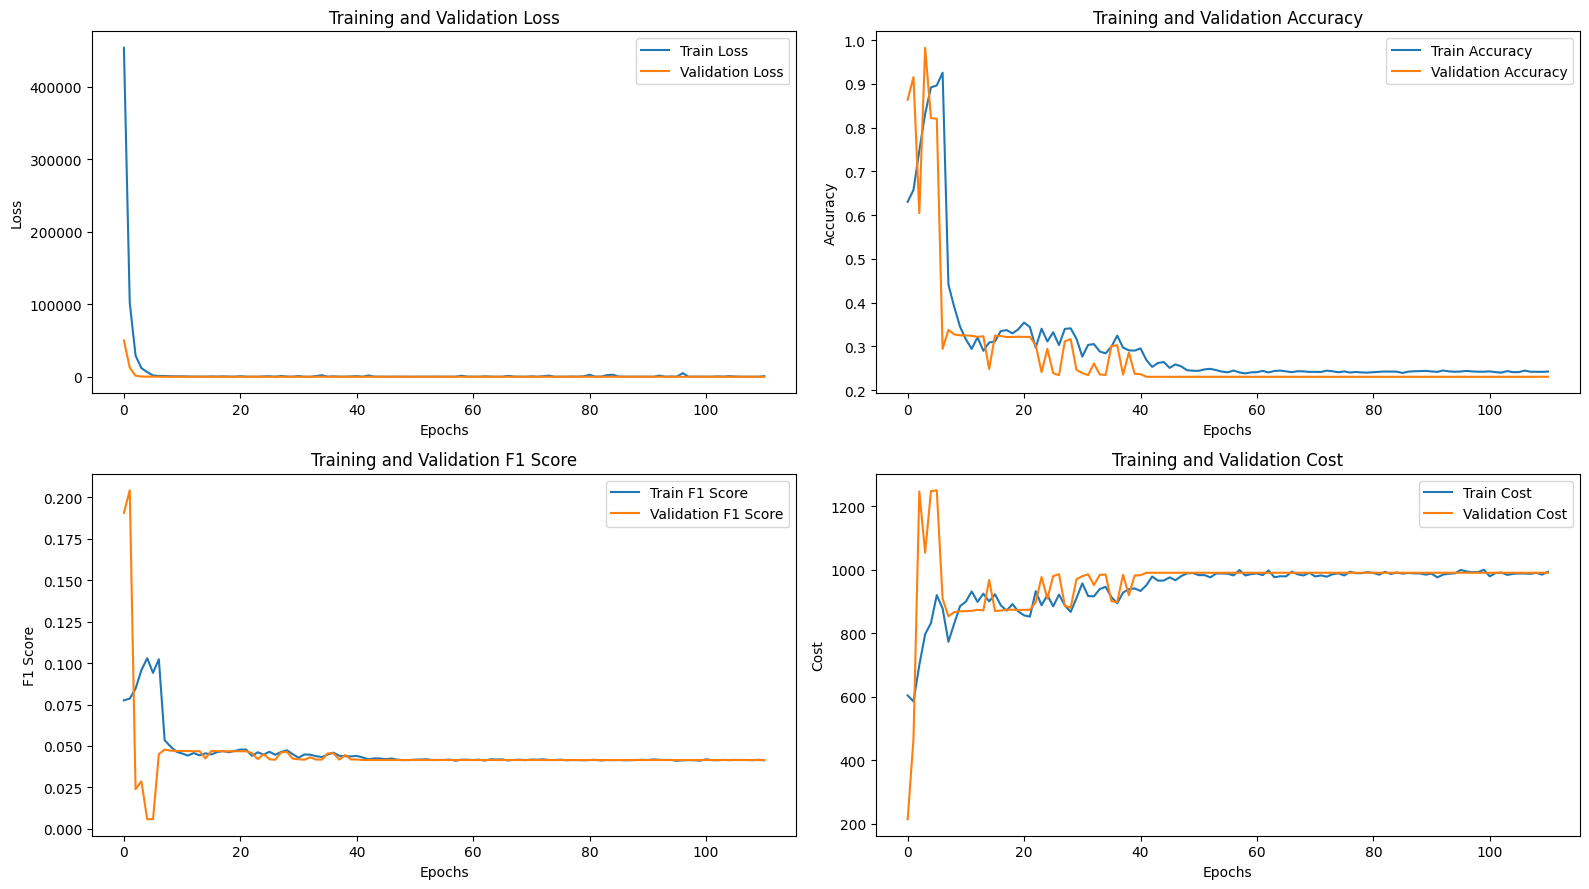

In [29]:
plot_training_history(train_loss_history, train_acc_history, train_f1_history, train_cost_history, 
                      valid_loss_history, valid_acc_history, valid_f1_history, valid_cost_history)

에러 수정 기록
1. RuntimeError: "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Float' : [티스토리](https://data-science.tistory.com/170)
2. RuntimeError: CUDA error: device-side assert triggered : [티스토리](https://wsshin.tistory.com/12)